In [1]:
from google.colab import files

uploaded = files.upload()

Saving iswc.json to iswc.json


In [2]:
import json

with open('iswc.json', 'r') as file:
     iswc = json.load(file)

## JSON input conversion
### From:
[{"year": year,
  "tkg": link,
  "metrics": [{"metric": metric_name,
               "concepts": [{uri: value},
                            (...)]},
              (...)]},
 (...)]
 
 ### To:
{metric_name: {uri: {year: value,
                     (...)},
               (...)},
 (...)}

In [3]:
all_concepts = set()
all_metrics = set()
all_years = set()

data = dict()

for entry in iswc:
    year = entry['year']
    all_years.add(year)
    for metrics in entry['metrics']:
        metric_name = metrics['metric']
        all_metrics.add(metric_name)
        metric_concepts = metrics['concepts']
        for concept in metric_concepts:
            for key, value in concept.items():
                all_concepts.add(key)
                #print("{} : {} : {} : {} ".format(metric_name, year, key, value))
                curr = {key: {year: value}}
                if metric_name in data.keys():
                    if key in data[metric_name].keys():
                        data[metric_name][key].update(curr[key])
                    else:
                        data[metric_name].update(curr)
                else:
                    data[metric_name] = curr

print('# of concepts: {}'.format(len(all_concepts)))
print('# of metrics: {}'.format(len(all_metrics)))
print('# of editions: {} ({} to {})'.format(len(all_years),\
                                            min(all_years), max(all_years)))

# of concepts: 958
# of metrics: 12
# of editions: 19 (2002 to 2020)


### Method to create a dataframe for a metric's annual data

In [4]:
import pandas as pd

def create_df(metric=None, verbose=False):
    df = pd.DataFrame(data[metric]).sort_index(ascending=True)
    if verbose:
        print(f'Annual data for {metric}')
        display(df)
    return df

### Method to print the TKGVR for a given metric data

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

def plot_df_heatmap(df, title="", dpi=100, num_lines=len(all_concepts)):
    df_t = df.transpose()
    # Sort by descending amount of NaNs
    df_heat = df_t.iloc[df_t.isnull().sum(axis=1).mul(1).argsort()].head(num_lines)
    plt.figure(figsize=(8, 6), dpi=dpi)
    ax = sns.heatmap(df_heat, yticklabels=num_lines<=50, square=False, cmap='Oranges')
    plt.title(title)
    plt.show()

## Print all metric's data and plot their TKGVR

Annual data for katz


,http://local/local.owl#semantic_web,http://local/local.owl#semantics,http://local/local.owl#ontologies,http://local/local.owl#rdf_data,http://local/local.owl#ontology,http://local/local.owl#rdf,http://local/local.owl#semantic_web_technologies,http://local/local.owl#web_resources,http://local/local.owl#web_mining,http://local/local.owl#semantic_web_applications,http://local/local.owl#world_wide_web,http://local/local.owl#web_information,http://local/local.owl#software_agents,http://local/local.owl#software,http://local/local.owl#knowledge_sharing,http://local/local.owl#ontology_languages,http://local/local.owl#rdf_graphs,http://local/local.owl#web_services_descriptions,http://local/local.owl#information_retrieval,http://local/local.owl#xml,http://local/local.owl#semantic,http://local/local.owl#intelligent_software_agents,http://local/local.owl#artificial_intelligence,http://local/local.owl#knowledge_representation,http://local/local.owl#description_logics,http://local/local.owl#semantic_annotations,http://local/local.owl#application_layer,http://local/local.owl#petri_nets,http://local/local.owl#ontology_development,http://local/local.owl#ontology_engineering,http://local/local.owl#virtual_communities,http://local/local.owl#ontology_construction,http://local/local.owl#query_languages,http://local/local.owl#content_providers,http://local/local.owl#process_model,http://local/local.owl#process_models,http://local/local.owl#collaborative_work,http://local/local.owl#grid_services,http://local/local.owl#inference_engine,http://local/local.owl#statistical_analysis,...,http://local/local.owl#type_safety,http://local/local.owl#graphbased_representation,http://local/local.owl#multihop,http://local/local.owl#sat_solver,http://local/local.owl#complex_question,http://local/local.owl#heterogeneous_databases,http://local/local.owl#peertopeer_systems,http://local/local.owl#mechanism_design,http://local/local.owl#interpretability,http://local/local.owl#computing_systems,http://local/local.owl#relational_learning,http://local/local.owl#random_walk_algorithm,http://local/local.owl#syntactic__information,http://local/local.owl#truthful_mechanisms,http://local/local.owl#statistic,http://local/local.owl#raster_data,http://local/local.owl#data_protection,http://local/local.owl#query_optimizer,http://local/local.owl#interpreter,http://local/local.owl#web_graph,http://local/local.owl#random_walks,http://local/local.owl#classification_models,http://local/local.owl#classification_approaches,http://local/local.owl#classification_model,http://local/local.owl#search_behaviors,http://local/local.owl#steiner_tree,http://local/local.owl#combinatorial_optimization_problem,http://local/local.owl#search_session,http://local/local.owl#syntactic_structure,http://local/local.owl#gaussian_distributions,http://local/local.owl#text_categorization,http://local/local.owl#similar_cases,http://local/local.owl#boosting,http://local/local.owl#cold_start_problem,http://local/local.owl#collaborative_filtering,http://local/local.owl#efficient_computation,http://local/local.owl#cold_start,http://local/local.owl#online_learning,http://local/local.owl#supervised_classifiers,http://local/local.owl#interleaves
2002,0.088126,0.039381,0.037669,0.030975,0.030077,0.028741,0.027612,0.026860,0.025263,0.023532,0.021901,0.021543,0.021103,0.019095,0.018733,0.017875,0.017756,0.01766,0.017546,0.017543,0.017531,0.01745,0.017396,0.017359,0.017085,0.016889,0.016804,0.016719,0.016523,0.016511,0.0165,0.016389,0.016355,0.016332,0.016263,0.016220,0.016207,0.016206,0.016114,0.016071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003,0.045479,0.038530,NaN,0.012137,0.047982,0.023364,0.017671,0.020634,NaN,NaN,0.019710,NaN,0.013172,0.010999,NaN,0.020234,0.013364,NaN,0.017764,0.012126,0.022610,NaN,NaN,NaN,0.013712,0.014139,NaN,NaN,0.017765,NaN,NaN,0.017015,0.013654,NaN,0.016804,NaN,NaN,NaN,

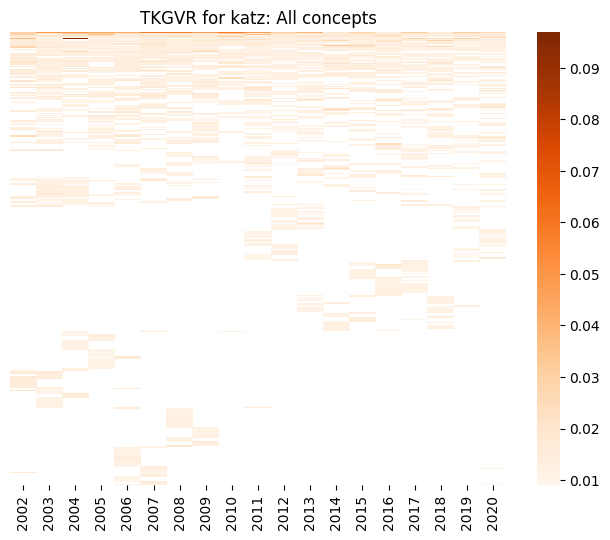

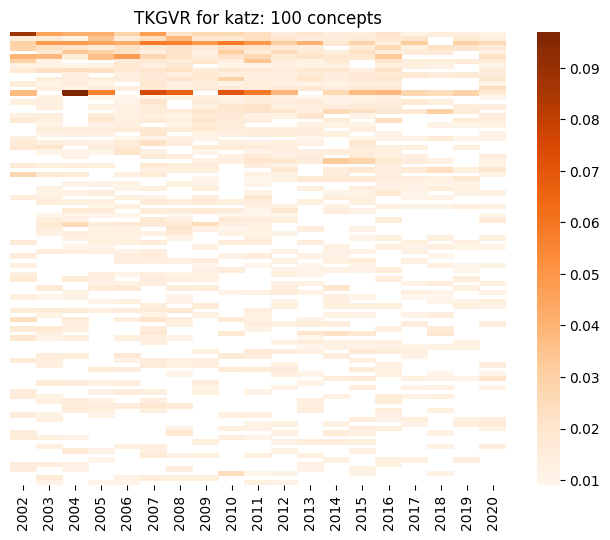

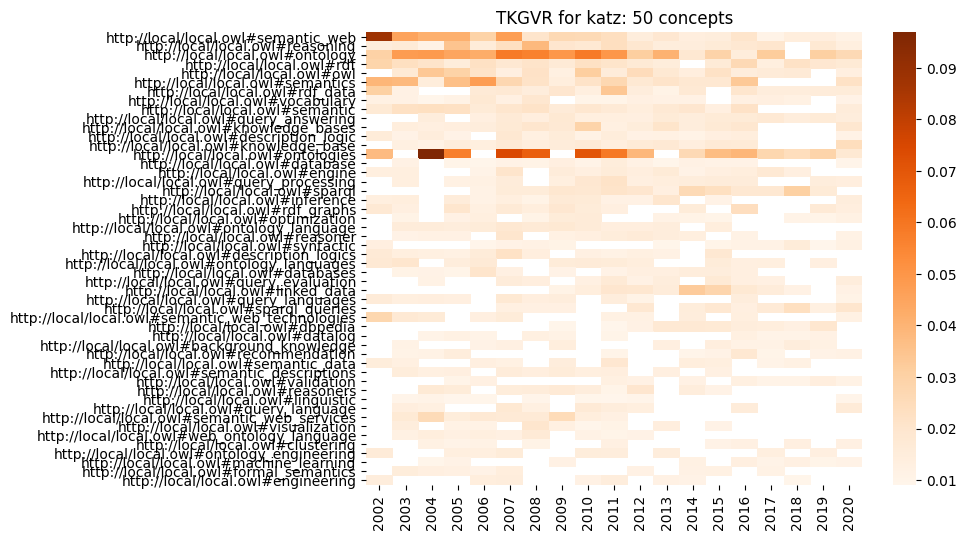

Annual data for betweenness


,http://local/local.owl#semantic_web,http://local/local.owl#rdf,http://local/local.owl#web_information,http://local/local.owl#knowledge_sharing,http://local/local.owl#ontology,http://local/local.owl#software,http://local/local.owl#software_agents,http://local/local.owl#rdf_graphs,http://local/local.owl#world_wide_web,http://local/local.owl#resource_sharing,http://local/local.owl#domain_ontology,http://local/local.owl#semantic,http://local/local.owl#intelligent_software_agents,http://local/local.owl#ontology_engineering,http://local/local.owl#collaborative_work,http://local/local.owl#engineering,http://local/local.owl#process_model,http://local/local.owl#learning_objects,http://local/local.owl#content_providers,http://local/local.owl#ontology_construction,http://local/local.owl#information_retrieval,http://local/local.owl#semantic_web_technologies,http://local/local.owl#ontology_development,http://local/local.owl#web_resources,http://local/local.owl#domain_experts,http://local/local.owl#semantic_web_applications,http://local/local.owl#description_logic,http://local/local.owl#ontology_languages,http://local/local.owl#semantics,http://local/local.owl#resource_description_framework,http://local/local.owl#web_services_descriptions,http://local/local.owl#web_service_descriptions,http://local/local.owl#classification_approach,http://local/local.owl#web_mining,http://local/local.owl#ontologies,http://local/local.owl#rdf_data,http://local/local.owl#internet,http://local/local.owl#automation,http://local/local.owl#knowledge_representation,http://local/local.owl#logic_programming,...,http://local/local.owl#network_architecture,http://local/local.owl#computing_systems,http://local/local.owl#feature_models,http://local/local.owl#sales,http://local/local.owl#interpretability,http://local/local.owl#syntactic__information,http://local/local.owl#random_walk_algorithm,http://local/local.owl#local_reasoning,http://local/local.owl#graphbased_representation,http://local/local.owl#peertopeer_systems,http://local/local.owl#revenue,http://local/local.owl#sat_solver,http://local/local.owl#video_game,http://local/local.owl#truthful_mechanisms,http://local/local.owl#statistic,http://local/local.owl#random_walks,http://local/local.owl#raster_data,http://local/local.owl#text_categorization,http://local/local.owl#web_graph,http://local/local.owl#classification_model,http://local/local.owl#data_protection,http://local/local.owl#query_optimizer,http://local/local.owl#cold_start_problem,http://local/local.owl#combinatorial_optimization_problem,http://local/local.owl#interpreter,http://local/local.owl#boosting,http://local/local.owl#cold_start,http://local/local.owl#online_learning,http://local/local.owl#classification_approaches,http://local/local.owl#search_session,http://local/local.owl#classification_models,http://local/local.owl#search_behaviors,http://local/local.owl#syntactic_structure,http://local/local.owl#steiner_tree,http://local/local.owl#similar_cases,http://local/local.owl#gaussian_distributions,http://local/local.owl#collaborative_filtering,http://local/local.owl#efficient_computation,http://local/local.owl#supervised_classifiers,http://local/local.owl#interleaves
2002,0.007309,0.002274,0.001587,0.001140,0.001074,0.000776,7.417362e-04,0.000487,0.000428,0.000412,0.000383,0.000373,0.00037,0.000222,0.000153,0.000149,0.000127,0.000108,0.000102,0.000099,0.000093,0.000081,0.000074,0.000073,0.000073,0.000072,0.000069,0.000069,6.028285e-05,0.000058,0.000055,0.000053,0.000046,0.000044,0.000044,0.000043,4.072874e-05,3.638578e-05,0.000029,0.000022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003,0.020104,0.005244,NaN,NaN,0.012758,0.000003,6.101895e-05,0.000072,0.001229,0.001883,0.001000,0.009499,NaN,NaN,NaN,NaN,0.000076,NaN,NaN,0.000239,0.000525,0.000080,0.000094,0.000037,NaN,NaN,0.001158,0.000055,1.708968e-05,0.000598,NaN,NaN,NaN,NaN,NaN

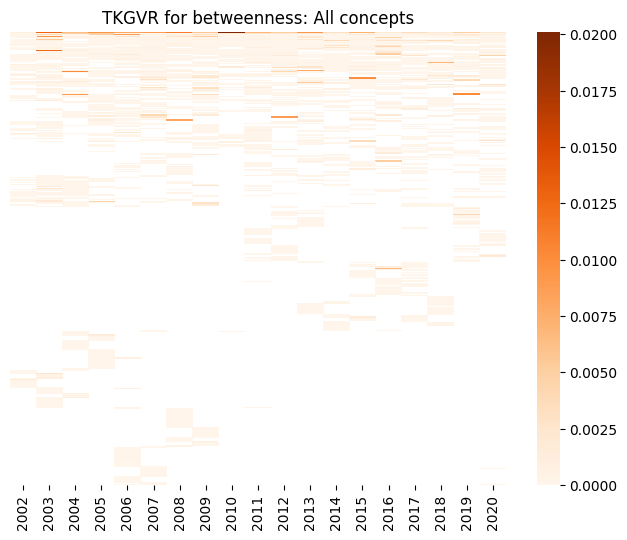

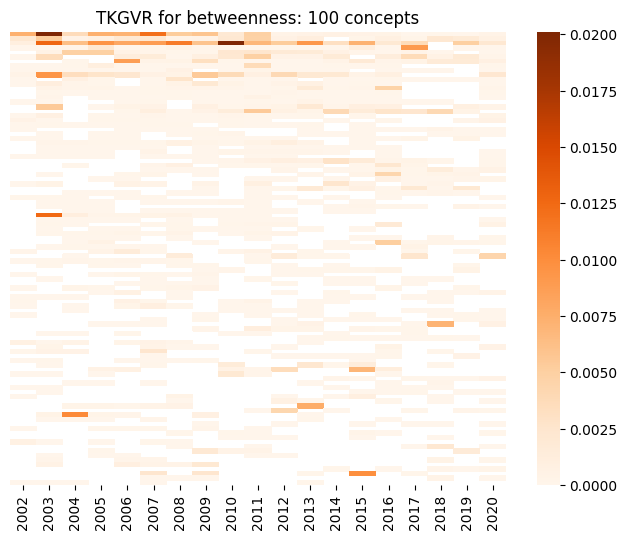

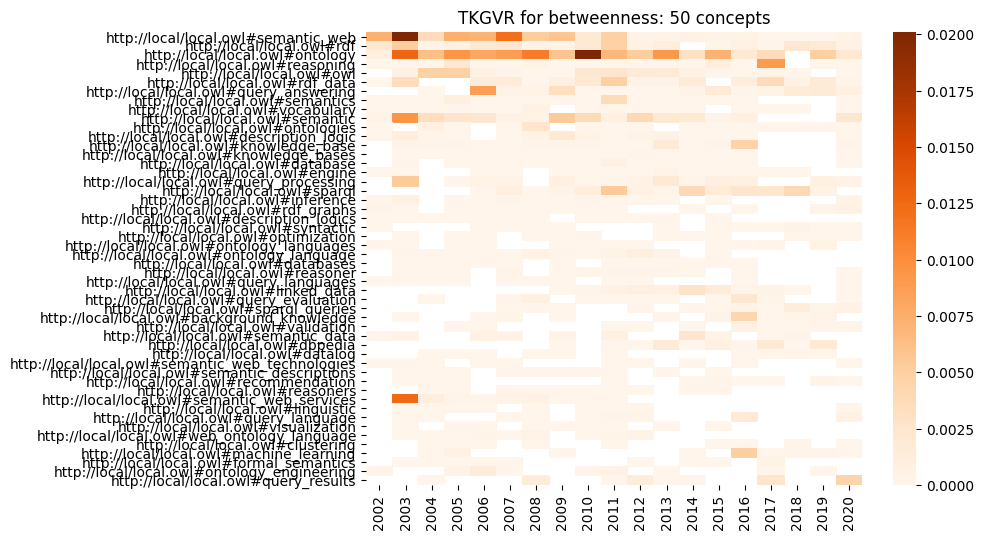

Annual data for voterank


,http://local/local.owl#semantic,http://local/local.owl#rdf,http://local/local.owl#semantic_web,http://local/local.owl#ontology,http://local/local.owl#xml,http://local/local.owl#resource_description_framework,http://local/local.owl#description_logic,http://local/local.owl#social_network,http://local/local.owl#social_network_analysis,http://local/local.owl#learning_objects,http://local/local.owl#open_source_project,http://local/local.owl#agentbased,http://local/local.owl#software,http://local/local.owl#relational_database_systems,http://local/local.owl#web_service_descriptions,http://local/local.owl#peertopeer,http://local/local.owl#layered,http://local/local.owl#semantic_web_applications,http://local/local.owl#semantic_web_technologies,http://local/local.owl#web_resources,http://local/local.owl#inference_engine,http://local/local.owl#education,http://local/local.owl#internet,http://local/local.owl#logic_programming,http://local/local.owl#business_environment,http://local/local.owl#rdf_graphs,http://local/local.owl#web_mining,http://local/local.owl#ecommerce,http://local/local.owl#syntactic,http://local/local.owl#bayesian,http://local/local.owl#electronic_commerce,http://local/local.owl#ontology_construction,http://local/local.owl#consistency_checking,http://local/local.owl#ontology_engineering,http://local/local.owl#reasoning,http://local/local.owl#domain_experts,http://local/local.owl#process_models,http://local/local.owl#visual_analytics,http://local/local.owl#vocabulary,http://local/local.owl#content_providers,...,http://local/local.owl#skyline_query,http://local/local.owl#type_safety,http://local/local.owl#truthful_mechanisms,http://local/local.owl#local_reasoning,http://local/local.owl#exact_solution,http://local/local.owl#feature_models,http://local/local.owl#peertopeer_systems,http://local/local.owl#computing_systems,http://local/local.owl#sales,http://local/local.owl#interpretability,http://local/local.owl#word_embeddings,http://local/local.owl#syntactic__information,http://local/local.owl#graphbased_representation,http://local/local.owl#similarity_query,http://local/local.owl#complex_question,http://local/local.owl#cold_start_problem,http://local/local.owl#boosting,http://local/local.owl#interleaves,http://local/local.owl#text_categorization,http://local/local.owl#data_protection,http://local/local.owl#query_optimizer,http://local/local.owl#search_behaviors,http://local/local.owl#similar_cases,http://local/local.owl#random_walks,http://local/local.owl#combinatorial_optimization_problem,http://local/local.owl#collaborative_filtering,http://local/local.owl#cold_start,http://local/local.owl#search_session,http://local/local.owl#steiner_tree,http://local/local.owl#supervised_classifiers,http://local/local.owl#efficient_computation,http://local/local.owl#gaussian_distributions,http://local/local.owl#web_graph,http://local/local.owl#classification_model,http://local/local.owl#interpreter,http://local/local.owl#raster_data,http://local/local.owl#classification_approaches,http://local/local.owl#online_learning,http://local/local.owl#syntactic_structure,http://local/local.owl#classification_models
2002,2442.0,2440.0,2433,2429.0,2404.0,2376.0,2355.0,2340.0,2332.0,2331.0,2328.0,2326.0,2321.0,2310.0,2304.0,2302.0,2300.0,2298.0,2297.0,2272.0,2271.0,2267.0,2263.0,2260.0,2250.0,2245.0,2216.0,2215.0,2211.0,2204.0,2200.0,2199.0,2188.0,2166.0,2157.0,2146.0,2144.0,2143.0,2142.0,2139.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003,3624.0,3597.0,3618,3611.0,3449.0,2890.0,3437.0,NaN,NaN,NaN,NaN,NaN,3368.0,NaN,NaN,NaN,NaN,NaN,3049.0,1981.0,3201.0,NaN,2508.0,NaN,NaN,2317.0,NaN,NaN,NaN,NaN,NaN,2942.0,NaN,NaN,2837.0,NaN,NaN,NaN,2527.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004,3839.0,3802.0,3837

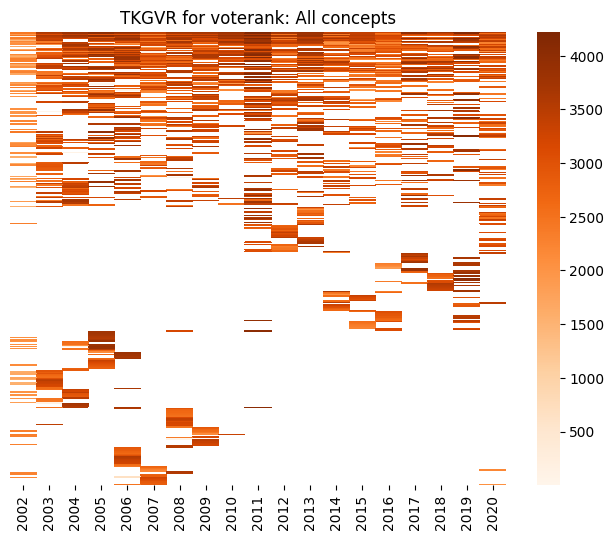

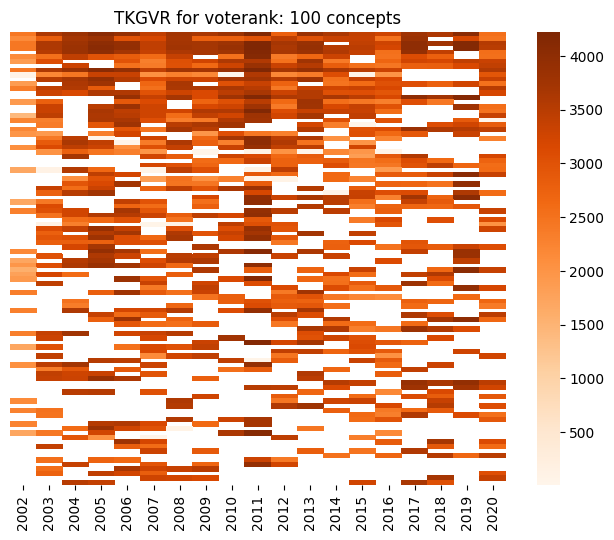

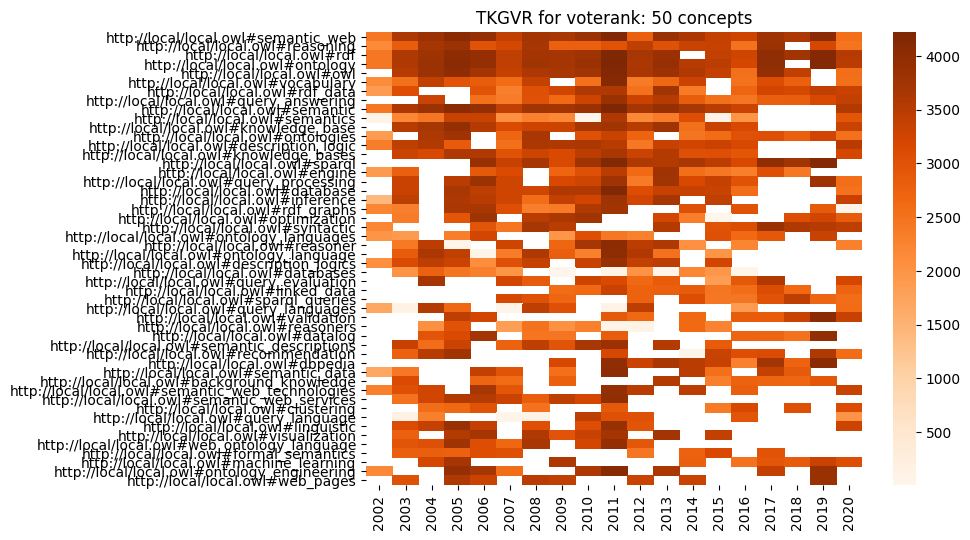

Annual data for outdegree


,http://local/local.owl#semantic,http://local/local.owl#rdf,http://local/local.owl#semantic_web,http://local/local.owl#ontology,http://local/local.owl#xml,http://local/local.owl#software,http://local/local.owl#resource_description_framework,http://local/local.owl#learning_objects,http://local/local.owl#description_logic,http://local/local.owl#relational_database_systems,http://local/local.owl#web_service_descriptions,http://local/local.owl#peertopeer,http://local/local.owl#layered,http://local/local.owl#semantic_web_applications,http://local/local.owl#semantic_web_technologies,http://local/local.owl#intelligent_software_agents,http://local/local.owl#social_network,http://local/local.owl#web_information,http://local/local.owl#web_services_descriptions,http://local/local.owl#social_network_analysis,http://local/local.owl#domain_ontology,http://local/local.owl#open_source_project,http://local/local.owl#agentbased,http://local/local.owl#text_classification,http://local/local.owl#web_resources,http://local/local.owl#information_retrieval,http://local/local.owl#inference_engine,http://local/local.owl#resource_sharing,http://local/local.owl#rdf_data,http://local/local.owl#education,http://local/local.owl#internet,http://local/local.owl#elearning,http://local/local.owl#logic_programming,http://local/local.owl#virtual_community,http://local/local.owl#business_environment,http://local/local.owl#rdf_graphs,http://local/local.owl#software_agents,http://local/local.owl#web_mining,http://local/local.owl#ecommerce,http://local/local.owl#syntactic,...,http://local/local.owl#exact_solution,http://local/local.owl#statistic,http://local/local.owl#feature_models,http://local/local.owl#random_walk_algorithm,http://local/local.owl#word_embeddings,http://local/local.owl#network_architecture,http://local/local.owl#sat_solver,http://local/local.owl#syntactic__information,http://local/local.owl#graphbased_representation,http://local/local.owl#type_safety,http://local/local.owl#similarity_query,http://local/local.owl#complex_question,http://local/local.owl#truthful_mechanisms,http://local/local.owl#sales,http://local/local.owl#interpretability,http://local/local.owl#cold_start_problem,http://local/local.owl#interleaves,http://local/local.owl#boosting,http://local/local.owl#data_protection,http://local/local.owl#combinatorial_optimization_problem,http://local/local.owl#cold_start,http://local/local.owl#text_categorization,http://local/local.owl#syntactic_structure,http://local/local.owl#web_graph,http://local/local.owl#classification_model,http://local/local.owl#query_optimizer,http://local/local.owl#raster_data,http://local/local.owl#gaussian_distributions,http://local/local.owl#search_behaviors,http://local/local.owl#classification_models,http://local/local.owl#similar_cases,http://local/local.owl#random_walks,http://local/local.owl#collaborative_filtering,http://local/local.owl#classification_approaches,http://local/local.owl#search_session,http://local/local.owl#online_learning,http://local/local.owl#steiner_tree,http://local/local.owl#supervised_classifiers,http://local/local.owl#efficient_computation,http://local/local.owl#interpreter
2002,0.003118,0.002910,0.002702,0.001871,0.001247,0.001247,0.001039,0.001039,0.000831,0.000831,0.000831,0.000831,0.000831,0.000831,0.000831,0.000831,0.000831,0.000831,0.000831,0.000831,0.000831,0.000831,0.000831,0.000831,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003,0.004503,0.001407,0.003096,0.001970,0.000563,0.000563,0.000563,NaN,0.000563,NaN,NaN,NaN,NaN,NaN,0.000563,NaN,NaN,NaN,NaN,NaN,0.000422,NaN,NaN,NaN,0.000422,0.000563,0.000422,0.000422,0.000563,NaN,0.000281,0.000422,NaN,NaN,NaN,0.000422,0.000422,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

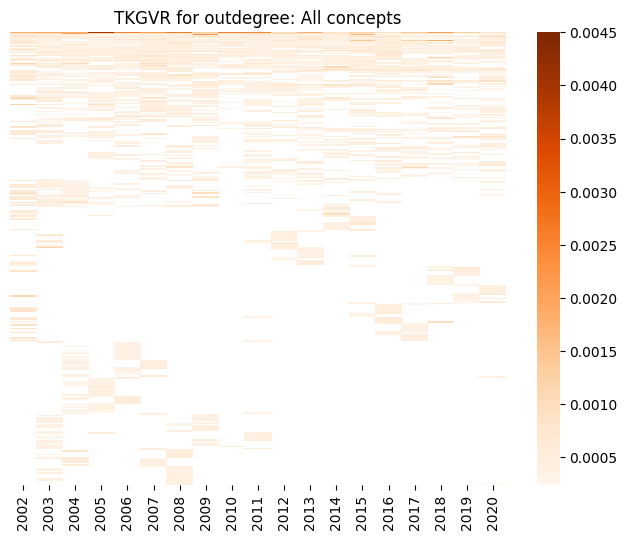

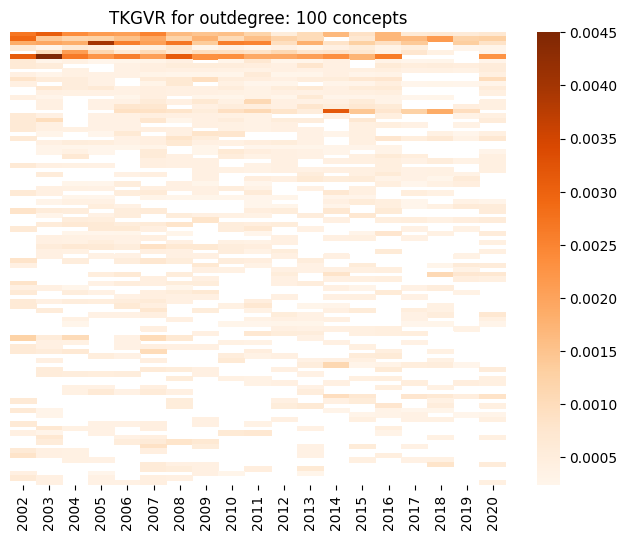

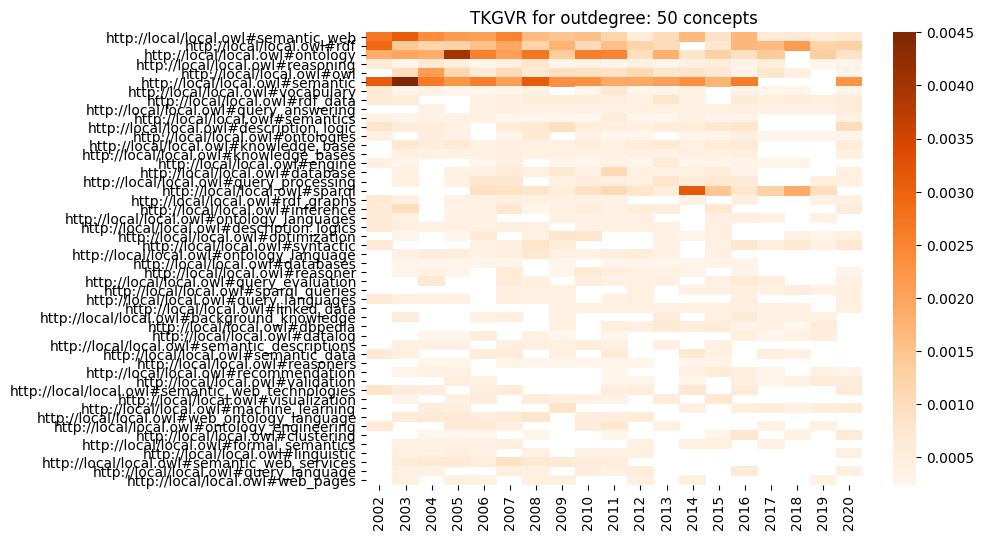

Annual data for harmonic


,http://local/local.owl#ontologies,http://local/local.owl#semantic_web,http://local/local.owl#ontology,http://local/local.owl#web_resources,http://local/local.owl#web_mining,http://local/local.owl#web_information,http://local/local.owl#semantic_web_technologies,http://local/local.owl#semantics,http://local/local.owl#ontology_languages,http://local/local.owl#ontology_development,http://local/local.owl#ontology_engineering,http://local/local.owl#web_services_descriptions,http://local/local.owl#ontology_construction,http://local/local.owl#semantic_web_applications,http://local/local.owl#content_providers,http://local/local.owl#information_retrieval,http://local/local.owl#engineering,http://local/local.owl#web_service_descriptions,http://local/local.owl#automation,http://local/local.owl#software_agents,http://local/local.owl#rdf_data,http://local/local.owl#rdf,http://local/local.owl#process_model,http://local/local.owl#learning_objects,http://local/local.owl#software,http://local/local.owl#rdf_graphs,http://local/local.owl#domain_experts,http://local/local.owl#domain_ontology,http://local/local.owl#description_logics,http://local/local.owl#description_logic,http://local/local.owl#logic_programming,http://local/local.owl#process_models,http://local/local.owl#knowledge_sharing,http://local/local.owl#knowledge_representation,http://local/local.owl#business_environment,http://local/local.owl#resource_sharing,http://local/local.owl#world_wide_web,http://local/local.owl#resource_description_framework,http://local/local.owl#application_layer,http://local/local.owl#classification_approach,...,http://local/local.owl#word_embeddings,http://local/local.owl#type_safety,http://local/local.owl#local_reasoning,http://local/local.owl#revenue,http://local/local.owl#graphbased_representation,http://local/local.owl#multihop,http://local/local.owl#video_game,http://local/local.owl#complex_question,http://local/local.owl#heterogeneous_databases,http://local/local.owl#sat_solver,http://local/local.owl#peertopeer_systems,http://local/local.owl#random_walk_algorithm,http://local/local.owl#syntactic__information,http://local/local.owl#truthful_mechanisms,http://local/local.owl#statistic,http://local/local.owl#data_protection,http://local/local.owl#raster_data,http://local/local.owl#query_optimizer,http://local/local.owl#web_graph,http://local/local.owl#interpreter,http://local/local.owl#random_walks,http://local/local.owl#text_categorization,http://local/local.owl#classification_models,http://local/local.owl#classification_model,http://local/local.owl#search_behaviors,http://local/local.owl#classification_approaches,http://local/local.owl#syntactic_structure,http://local/local.owl#search_session,http://local/local.owl#combinatorial_optimization_problem,http://local/local.owl#steiner_tree,http://local/local.owl#gaussian_distributions,http://local/local.owl#similar_cases,http://local/local.owl#boosting,http://local/local.owl#cold_start_problem,http://local/local.owl#collaborative_filtering,http://local/local.owl#efficient_computation,http://local/local.owl#cold_start,http://local/local.owl#online_learning,http://local/local.owl#supervised_classifiers,http://local/local.owl#interleaves
2002,126.604888,116.613728,102.547772,94.513674,91.007325,88.481495,87.443659,86.707037,86.021048,83.936982,83.763906,83.468472,83.138906,82.110326,76.091557,73.854988,72.866542,70.468313,70.418313,69.634580,64.393792,62.493671,62.050665,56.34247,54.815451,53.299347,51.864221,50.717792,27.189391,26.189391,22.946698,22.934957,22.878571,22.445238,18.062374,14.940981,14.683333,13.270982,11.984524,11.767857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003,NaN,240.108353,256.439684,198.542291,NaN,NaN,199.008955,195.667240,209.274515,207.828690,NaN,NaN,207.342975,NaN,NaN,212.393729,NaN,NaN,2.833333,148.474970,167.306122,202.057850,171.084043,NaN,4.483333,169.667234

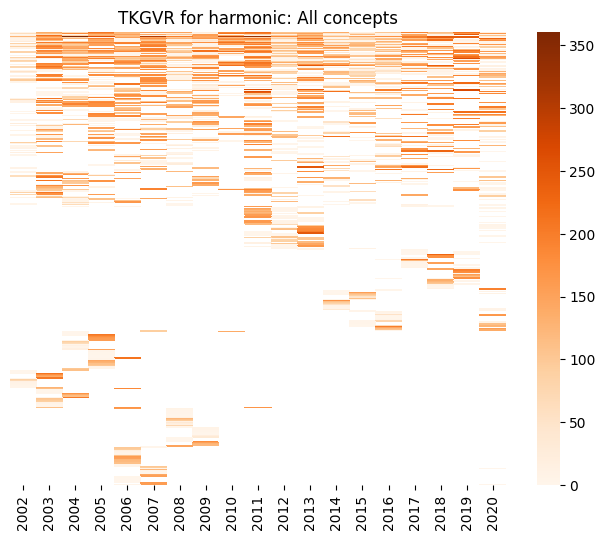

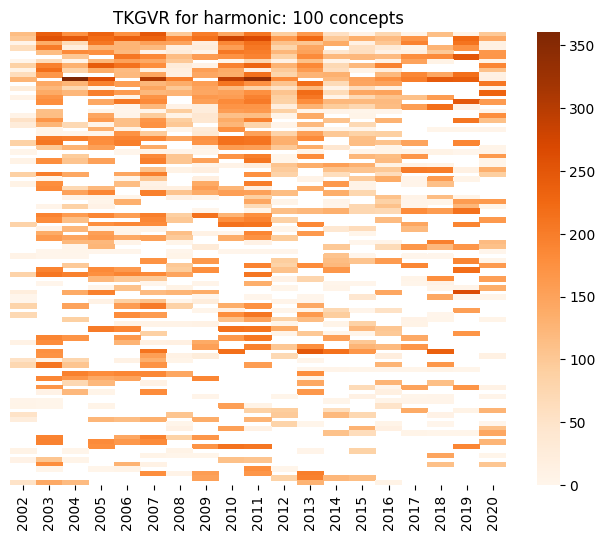

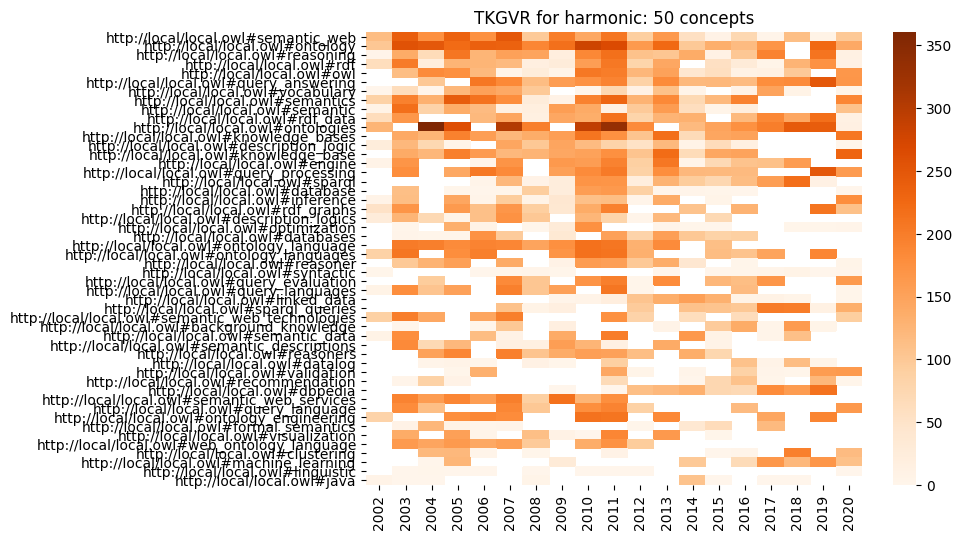

Annual data for indegree


,http://local/local.owl#semantic_web,http://local/local.owl#semantics,http://local/local.owl#ontologies,http://local/local.owl#rdf_data,http://local/local.owl#rdf,http://local/local.owl#ontology,http://local/local.owl#world_wide_web,http://local/local.owl#semantic_web_technologies,http://local/local.owl#web_resources,http://local/local.owl#software,http://local/local.owl#software_agents,http://local/local.owl#xml,http://local/local.owl#web_mining,http://local/local.owl#knowledge_sharing,http://local/local.owl#semantic,http://local/local.owl#intelligent_software_agents,http://local/local.owl#artificial_intelligence,http://local/local.owl#inference_engine,http://local/local.owl#internet,http://local/local.owl#rdf_graphs,http://local/local.owl#virtual_communities,http://local/local.owl#application_layer,http://local/local.owl#semantic_web_applications,http://local/local.owl#statistical_analysis,http://local/local.owl#ontology_languages,http://local/local.owl#grid_services,http://local/local.owl#knowledge_representation,http://local/local.owl#semantic_annotations,http://local/local.owl#query_languages,http://local/local.owl#social_network_analysis,http://local/local.owl#description_logics,http://local/local.owl#collaborative_work,http://local/local.owl#open_source_project,http://local/local.owl#peertopeer_network,http://local/local.owl#petri_nets,http://local/local.owl#information_retrieval,http://local/local.owl#resource_sharing,http://local/local.owl#description_logic,http://local/local.owl#logic_programming,http://local/local.owl#virtual_community,...,http://local/local.owl#network_architecture,http://local/local.owl#sat_solver,http://local/local.owl#recommender_systems,http://local/local.owl#graphbased_representation,http://local/local.owl#type_safety,http://local/local.owl#complex_question,http://local/local.owl#heterogeneous_databases,http://local/local.owl#computing_systems,http://local/local.owl#mechanism_design,http://local/local.owl#interpretability,http://local/local.owl#random_walk_algorithm,http://local/local.owl#syntactic__information,http://local/local.owl#relational_learning,http://local/local.owl#truthful_mechanisms,http://local/local.owl#statistic,http://local/local.owl#raster_data,http://local/local.owl#interpreter,http://local/local.owl#query_optimizer,http://local/local.owl#boosting,http://local/local.owl#cold_start_problem,http://local/local.owl#syntactic_structure,http://local/local.owl#web_graph,http://local/local.owl#classification_model,http://local/local.owl#gaussian_distributions,http://local/local.owl#search_behaviors,http://local/local.owl#classification_models,http://local/local.owl#similar_cases,http://local/local.owl#random_walks,http://local/local.owl#combinatorial_optimization_problem,http://local/local.owl#collaborative_filtering,http://local/local.owl#classification_approaches,http://local/local.owl#search_session,http://local/local.owl#steiner_tree,http://local/local.owl#supervised_classifiers,http://local/local.owl#efficient_computation,http://local/local.owl#data_protection,http://local/local.owl#cold_start,http://local/local.owl#online_learning,http://local/local.owl#text_categorization,http://local/local.owl#interleaves
2002,0.010601,0.003949,0.003326,0.002702,0.002494,0.002494,0.001455,0.001247,0.001039,0.001039,0.001039,0.000831,0.000831,0.000831,0.000831,0.000831,0.000831,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000624,0.000416,0.000416,0.000416,0.000416,0.000416,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003,0.004221,0.003236,NaN,0.000141,0.001688,0.004362,0.001266,0.000422,0.000985,0.000141,0.000422,0.000281,NaN,NaN,0.000844,NaN,NaN,0.000422,0.000141,0.000281,NaN,NaN,NaN,NaN,0.000844,NaN,NaN,0.000422,0.000281,NaN,0.000422,NaN,NaN,NaN,NaN,0.000422,0.0002

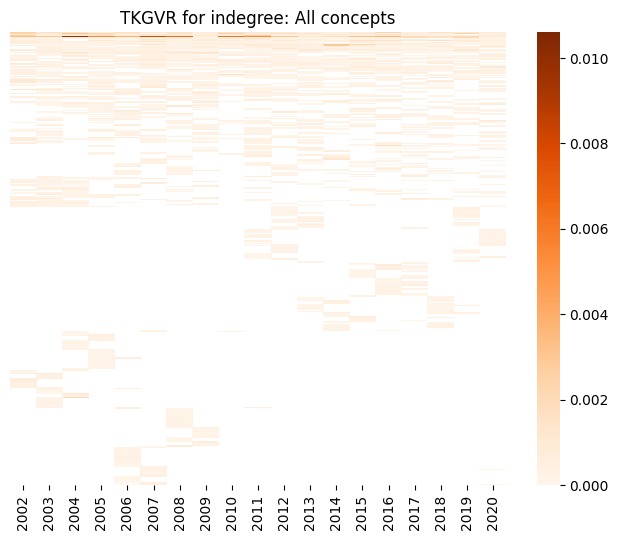

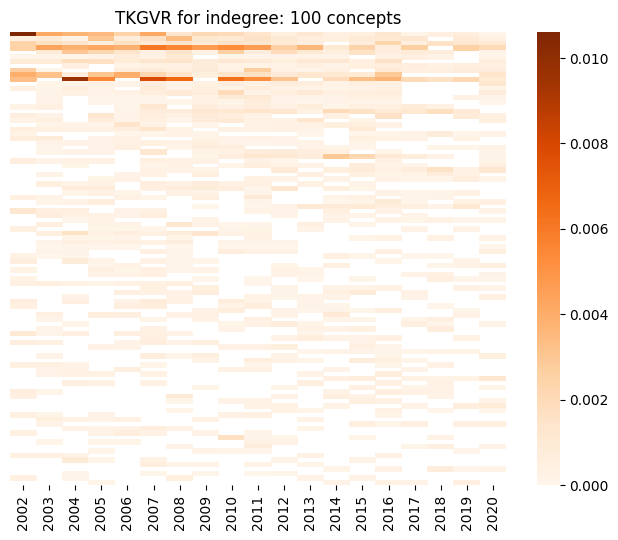

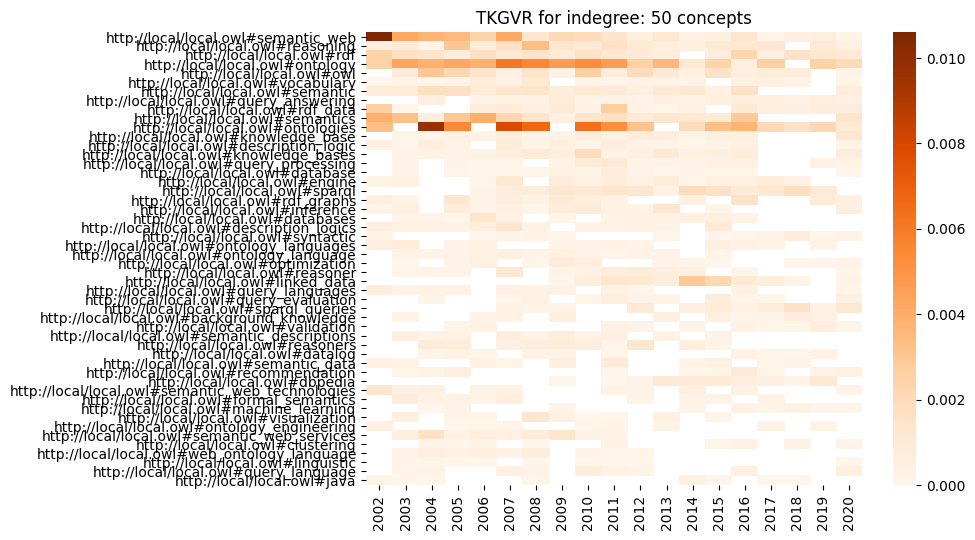

Annual data for pagerank


,http://local/local.owl#semantic_web,http://local/local.owl#semantics,http://local/local.owl#ontologies,http://local/local.owl#ontology,http://local/local.owl#rdf_data,http://local/local.owl#rdf,http://local/local.owl#content_providers,http://local/local.owl#semantic_web_technologies,http://local/local.owl#software_agents,http://local/local.owl#software,http://local/local.owl#web_mining,http://local/local.owl#process_model,http://local/local.owl#knowledge_sharing,http://local/local.owl#world_wide_web,http://local/local.owl#process_models,http://local/local.owl#ontology_languages,http://local/local.owl#semantic_web_applications,http://local/local.owl#xml,http://local/local.owl#description_logics,http://local/local.owl#artificial_intelligence,http://local/local.owl#knowledge_representation,http://local/local.owl#semantic,http://local/local.owl#haskell,http://local/local.owl#network_analysis,http://local/local.owl#information_retrieval,http://local/local.owl#intelligent_software_agents,http://local/local.owl#description_logic,http://local/local.owl#automation,http://local/local.owl#web_services_descriptions,http://local/local.owl#web_resources,http://local/local.owl#web_information,http://local/local.owl#ontology_development,http://local/local.owl#ontology_engineering,http://local/local.owl#communication,http://local/local.owl#logic_programming,http://local/local.owl#rdf_graphs,http://local/local.owl#application_layer,http://local/local.owl#consistency_checking,http://local/local.owl#classification_approach,http://local/local.owl#engineering,...,http://local/local.owl#interpretability,http://local/local.owl#sat_solver,http://local/local.owl#multihop,http://local/local.owl#heterogeneous_databases,http://local/local.owl#type_safety,http://local/local.owl#complex_question,http://local/local.owl#multicriteria_decision_making,http://local/local.owl#graphbased_representation,http://local/local.owl#peertopeer_systems,http://local/local.owl#truthful_mechanisms,http://local/local.owl#computing_systems,http://local/local.owl#random_walk_algorithm,http://local/local.owl#syntactic__information,http://local/local.owl#relational_learning,http://local/local.owl#statistic,http://local/local.owl#raster_data,http://local/local.owl#text_categorization,http://local/local.owl#data_protection,http://local/local.owl#interpreter,http://local/local.owl#query_optimizer,http://local/local.owl#steiner_tree,http://local/local.owl#random_walks,http://local/local.owl#web_graph,http://local/local.owl#search_behaviors,http://local/local.owl#gaussian_distributions,http://local/local.owl#classification_models,http://local/local.owl#classification_approaches,http://local/local.owl#combinatorial_optimization_problem,http://local/local.owl#classification_model,http://local/local.owl#collaborative_filtering,http://local/local.owl#syntactic_structure,http://local/local.owl#similar_cases,http://local/local.owl#search_session,http://local/local.owl#efficient_computation,http://local/local.owl#boosting,http://local/local.owl#cold_start_problem,http://local/local.owl#cold_start,http://local/local.owl#online_learning,http://local/local.owl#supervised_classifiers,http://local/local.owl#interleaves
2002,0.001862,0.001270,0.001133,0.001088,0.000609,0.000481,0.000473,0.000462,0.000411,0.000362,0.000351,0.000346,0.000332,0.000332,0.000328,0.000313,0.000310,0.000305,0.000304,0.000297,0.000295,0.000295,0.000293,0.000289,0.000286,0.000285,0.000283,0.000281,0.000281,0.000278,0.000277,0.000270,0.000267,0.000265,0.000261,0.000259,0.000258,0.000254,0.000243,0.000240,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003,0.000851,0.001054,NaN,0.001320,0.000121,0.000472,NaN,0.000124,0.000189,0.000138,NaN,0.000294,NaN,0.000271,NaN,0.000314,NaN,0.000170,0.000188,NaN,NaN,0.000251,NaN,NaN,0.000222,NaN,0.000118,0.000143,NaN,0.000259,NaN,0.000232,NaN,0.000139,NaN,0.000164,NaN,NaN,N

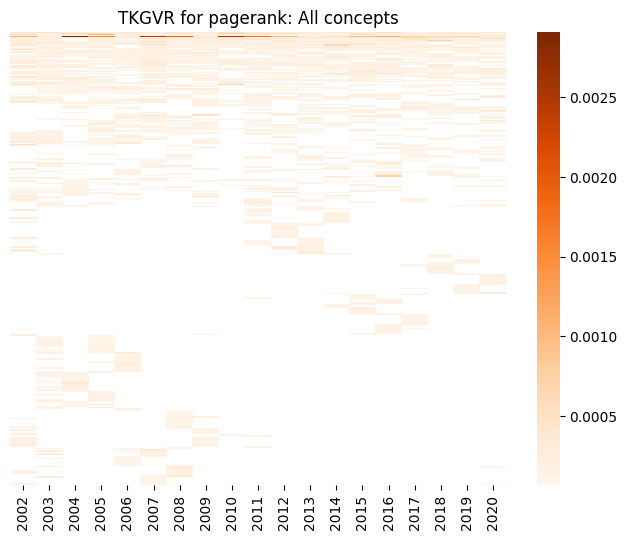

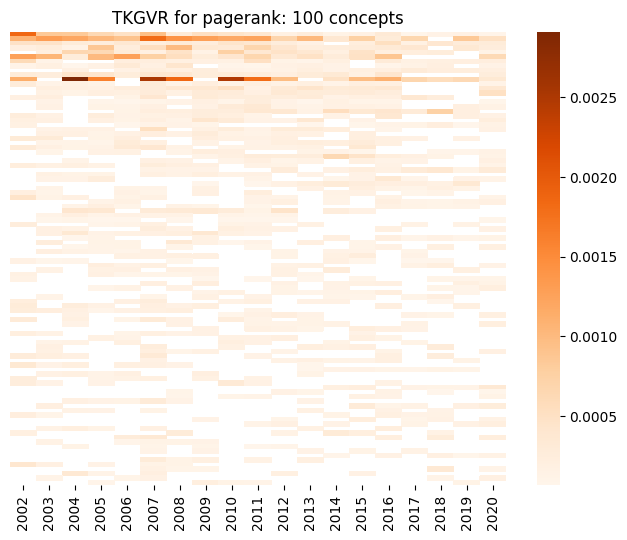

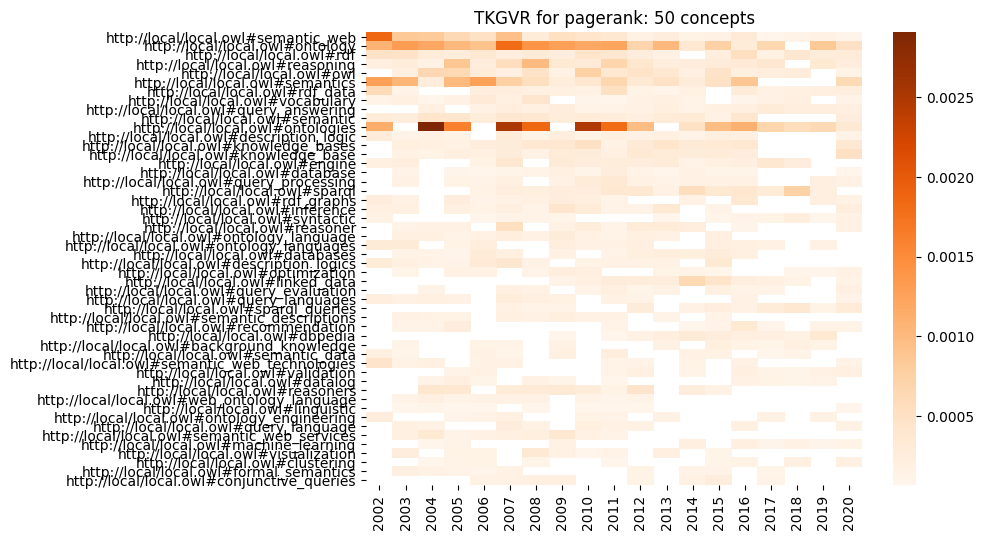

Annual data for closeness


,http://local/local.owl#ontologies,http://local/local.owl#ontology,http://local/local.owl#ontology_languages,http://local/local.owl#ontology_development,http://local/local.owl#ontology_engineering,http://local/local.owl#ontology_construction,http://local/local.owl#semantic_web,http://local/local.owl#web_resources,http://local/local.owl#engineering,http://local/local.owl#web_mining,http://local/local.owl#content_providers,http://local/local.owl#web_information,http://local/local.owl#web_services_descriptions,http://local/local.owl#semantic_web_technologies,http://local/local.owl#semantics,http://local/local.owl#semantic_web_applications,http://local/local.owl#information_retrieval,http://local/local.owl#automation,http://local/local.owl#web_service_descriptions,http://local/local.owl#software_agents,http://local/local.owl#process_model,http://local/local.owl#learning_objects,http://local/local.owl#domain_experts,http://local/local.owl#domain_ontology,http://local/local.owl#rdf,http://local/local.owl#rdf_data,http://local/local.owl#rdf_graphs,http://local/local.owl#software,http://local/local.owl#description_logics,http://local/local.owl#description_logic,http://local/local.owl#process_models,http://local/local.owl#knowledge_representation,http://local/local.owl#knowledge_sharing,http://local/local.owl#logic_programming,http://local/local.owl#business_environment,http://local/local.owl#resource_sharing,http://local/local.owl#world_wide_web,http://local/local.owl#resource_description_framework,http://local/local.owl#classification_approach,http://local/local.owl#application_layer,...,http://local/local.owl#word_embeddings,http://local/local.owl#type_safety,http://local/local.owl#revenue,http://local/local.owl#local_reasoning,http://local/local.owl#graphbased_representation,http://local/local.owl#multihop,http://local/local.owl#video_game,http://local/local.owl#complex_question,http://local/local.owl#heterogeneous_databases,http://local/local.owl#sat_solver,http://local/local.owl#peertopeer_systems,http://local/local.owl#random_walk_algorithm,http://local/local.owl#syntactic__information,http://local/local.owl#truthful_mechanisms,http://local/local.owl#statistic,http://local/local.owl#data_protection,http://local/local.owl#raster_data,http://local/local.owl#query_optimizer,http://local/local.owl#web_graph,http://local/local.owl#interpreter,http://local/local.owl#random_walks,http://local/local.owl#text_categorization,http://local/local.owl#classification_models,http://local/local.owl#classification_model,http://local/local.owl#search_behaviors,http://local/local.owl#classification_approaches,http://local/local.owl#syntactic_structure,http://local/local.owl#search_session,http://local/local.owl#combinatorial_optimization_problem,http://local/local.owl#steiner_tree,http://local/local.owl#gaussian_distributions,http://local/local.owl#similar_cases,http://local/local.owl#boosting,http://local/local.owl#cold_start_problem,http://local/local.owl#collaborative_filtering,http://local/local.owl#efficient_computation,http://local/local.owl#cold_start,http://local/local.owl#online_learning,http://local/local.owl#supervised_classifiers,http://local/local.owl#interleaves
2002,0.018421,0.015989,0.014392,0.014237,0.014222,0.014152,0.013240,0.013059,0.012826,0.012804,0.012803,0.012707,0.012586,0.012123,0.011921,0.011692,0.011185,0.011087,0.011064,0.010099,0.009828,0.00956,0.009254,0.009229,0.008970,0.008700,0.008343,0.008148,0.004047,0.003987,0.003815,0.003744,0.003704,0.003516,0.002928,0.002248,0.002227,0.002074,0.001959,0.001902,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003,NaN,0.027101,0.023992,0.024190,NaN,0.024164,0.025388,0.022514,NaN,NaN,NaN,NaN,NaN,0.022721,0.019727,NaN,0.024197,0.000352,NaN,0.018172,0.020258,NaN,NaN,0.016939,0.023464,0.020612,0.020733,0.000484,0.015485,0.015345,NaN,NaN,NaN,NaN,NaN,0.018358,0.010287,0

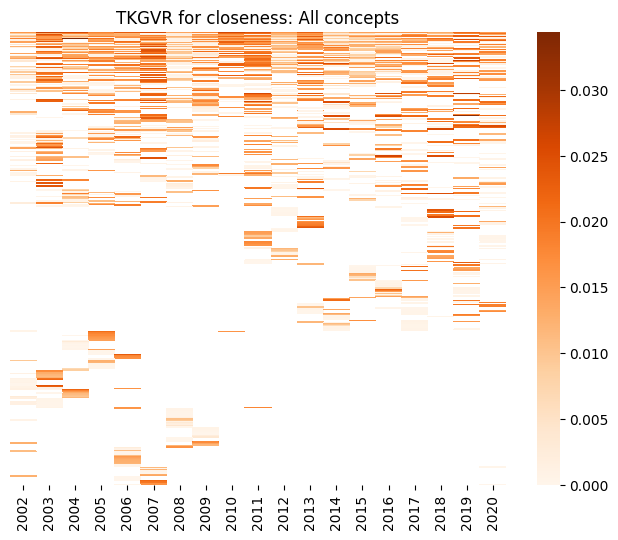

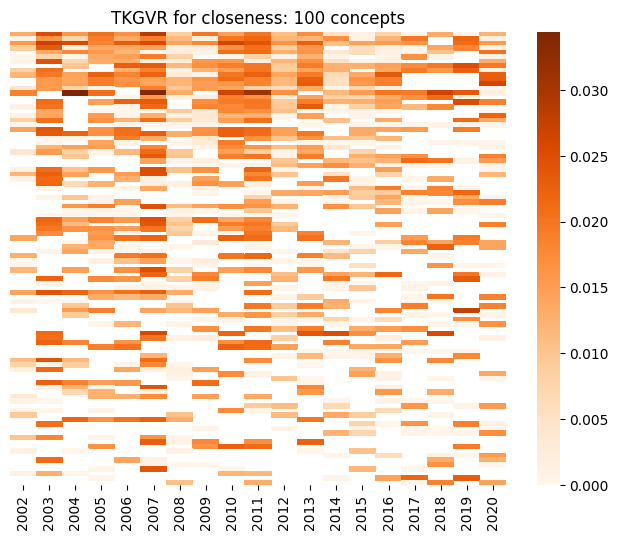

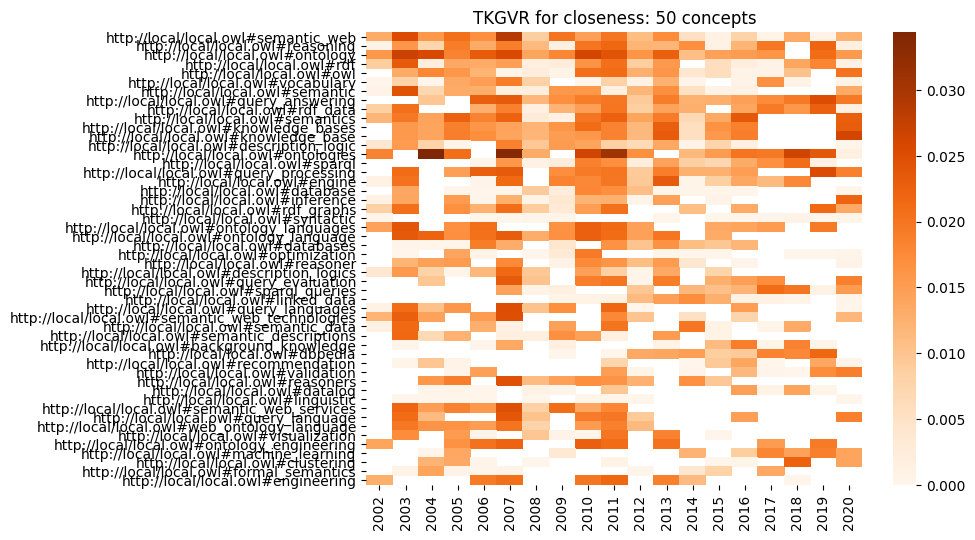

Annual data for load


,http://local/local.owl#semantic_web,http://local/local.owl#rdf,http://local/local.owl#web_information,http://local/local.owl#knowledge_sharing,http://local/local.owl#ontology,http://local/local.owl#software,http://local/local.owl#software_agents,http://local/local.owl#rdf_graphs,http://local/local.owl#world_wide_web,http://local/local.owl#resource_sharing,http://local/local.owl#domain_ontology,http://local/local.owl#semantic,http://local/local.owl#intelligent_software_agents,http://local/local.owl#ontology_engineering,http://local/local.owl#collaborative_work,http://local/local.owl#engineering,http://local/local.owl#process_model,http://local/local.owl#learning_objects,http://local/local.owl#content_providers,http://local/local.owl#ontology_construction,http://local/local.owl#information_retrieval,http://local/local.owl#semantic_web_technologies,http://local/local.owl#ontology_development,http://local/local.owl#web_resources,http://local/local.owl#domain_experts,http://local/local.owl#semantic_web_applications,http://local/local.owl#description_logic,http://local/local.owl#ontology_languages,http://local/local.owl#semantics,http://local/local.owl#resource_description_framework,http://local/local.owl#web_services_descriptions,http://local/local.owl#web_service_descriptions,http://local/local.owl#classification_approach,http://local/local.owl#web_mining,http://local/local.owl#ontologies,http://local/local.owl#rdf_data,http://local/local.owl#internet,http://local/local.owl#automation,http://local/local.owl#knowledge_representation,http://local/local.owl#logic_programming,...,http://local/local.owl#exact_solution,http://local/local.owl#computing_systems,http://local/local.owl#feature_models,http://local/local.owl#sales,http://local/local.owl#interpretability,http://local/local.owl#syntactic__information,http://local/local.owl#random_walk_algorithm,http://local/local.owl#local_reasoning,http://local/local.owl#graphbased_representation,http://local/local.owl#peertopeer_systems,http://local/local.owl#revenue,http://local/local.owl#sat_solver,http://local/local.owl#video_game,http://local/local.owl#truthful_mechanisms,http://local/local.owl#statistic,http://local/local.owl#random_walks,http://local/local.owl#raster_data,http://local/local.owl#text_categorization,http://local/local.owl#web_graph,http://local/local.owl#classification_model,http://local/local.owl#data_protection,http://local/local.owl#query_optimizer,http://local/local.owl#cold_start_problem,http://local/local.owl#combinatorial_optimization_problem,http://local/local.owl#interpreter,http://local/local.owl#boosting,http://local/local.owl#cold_start,http://local/local.owl#online_learning,http://local/local.owl#classification_approaches,http://local/local.owl#search_session,http://local/local.owl#classification_models,http://local/local.owl#search_behaviors,http://local/local.owl#syntactic_structure,http://local/local.owl#steiner_tree,http://local/local.owl#similar_cases,http://local/local.owl#gaussian_distributions,http://local/local.owl#collaborative_filtering,http://local/local.owl#efficient_computation,http://local/local.owl#supervised_classifiers,http://local/local.owl#interleaves
2002,0.007303,0.002276,0.001588,0.001141,0.001074,0.000757,7.229212e-04,0.000487,0.000428,0.000412,0.000383,0.000373,0.00037,0.000222,0.000153,0.000149,0.000127,0.000108,0.000102,0.000099,0.000093,0.000082,0.000074,0.000073,0.000073,0.000072,0.000069,0.000069,6.028285e-05,0.000059,0.000055,0.000053,0.000046,0.000044,0.000044,0.000043,4.075034e-05,3.638578e-05,0.000029,0.000022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003,0.019052,0.005247,NaN,NaN,0.012756,0.000003,6.258456e-05,0.000072,0.001229,0.001906,0.000999,0.008951,NaN,NaN,NaN,NaN,0.000076,NaN,NaN,0.000239,0.000524,0.000081,0.000094,0.000037,NaN,NaN,0.001174,0.000056,1.755364e-05,0.000595,NaN,NaN,NaN,NaN,NaN,0.003

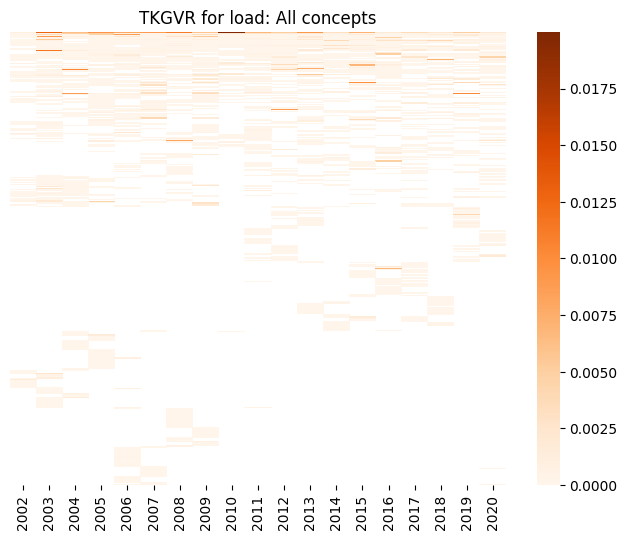

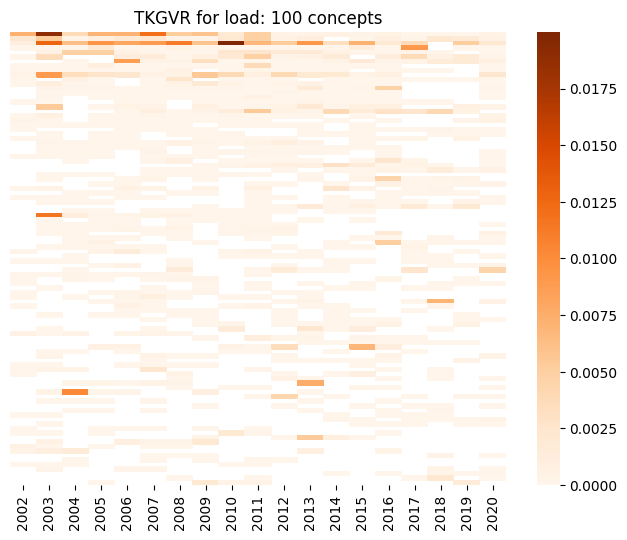

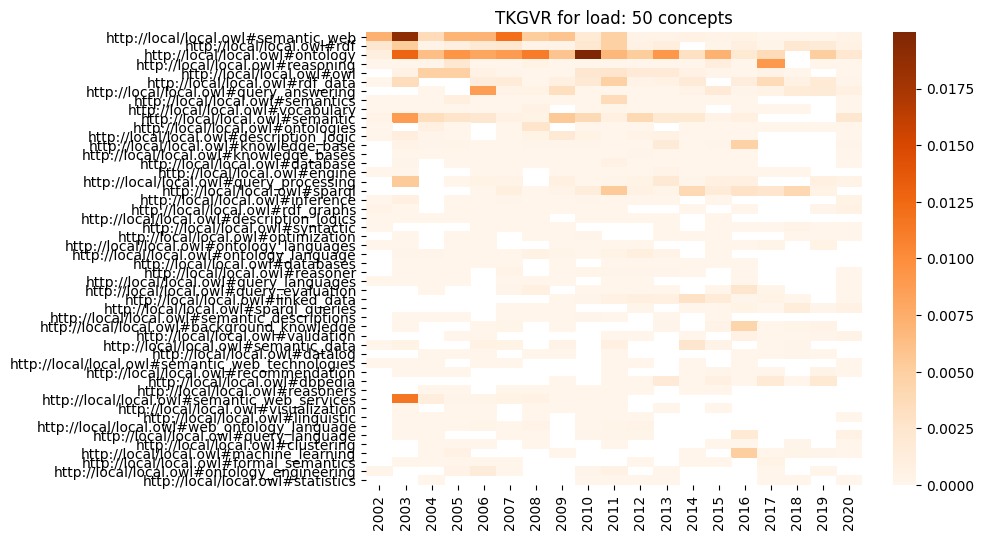

Annual data for percolation


,http://local/local.owl#semantic_web,http://local/local.owl#rdf,http://local/local.owl#web_information,http://local/local.owl#knowledge_sharing,http://local/local.owl#ontology,http://local/local.owl#software,http://local/local.owl#software_agents,http://local/local.owl#rdf_graphs,http://local/local.owl#world_wide_web,http://local/local.owl#resource_sharing,http://local/local.owl#domain_ontology,http://local/local.owl#semantic,http://local/local.owl#intelligent_software_agents,http://local/local.owl#ontology_engineering,http://local/local.owl#collaborative_work,http://local/local.owl#engineering,http://local/local.owl#process_model,http://local/local.owl#learning_objects,http://local/local.owl#content_providers,http://local/local.owl#ontology_construction,http://local/local.owl#information_retrieval,http://local/local.owl#semantic_web_technologies,http://local/local.owl#ontology_development,http://local/local.owl#web_resources,http://local/local.owl#domain_experts,http://local/local.owl#semantic_web_applications,http://local/local.owl#description_logic,http://local/local.owl#ontology_languages,http://local/local.owl#semantics,http://local/local.owl#resource_description_framework,http://local/local.owl#web_services_descriptions,http://local/local.owl#web_service_descriptions,http://local/local.owl#classification_approach,http://local/local.owl#web_mining,http://local/local.owl#ontologies,http://local/local.owl#rdf_data,http://local/local.owl#internet,http://local/local.owl#automation,http://local/local.owl#knowledge_representation,http://local/local.owl#logic_programming,...,http://local/local.owl#network_architecture,http://local/local.owl#computing_systems,http://local/local.owl#feature_models,http://local/local.owl#sales,http://local/local.owl#interpretability,http://local/local.owl#syntactic__information,http://local/local.owl#random_walk_algorithm,http://local/local.owl#local_reasoning,http://local/local.owl#graphbased_representation,http://local/local.owl#peertopeer_systems,http://local/local.owl#revenue,http://local/local.owl#sat_solver,http://local/local.owl#video_game,http://local/local.owl#truthful_mechanisms,http://local/local.owl#statistic,http://local/local.owl#random_walks,http://local/local.owl#raster_data,http://local/local.owl#text_categorization,http://local/local.owl#web_graph,http://local/local.owl#classification_model,http://local/local.owl#data_protection,http://local/local.owl#query_optimizer,http://local/local.owl#cold_start_problem,http://local/local.owl#combinatorial_optimization_problem,http://local/local.owl#interpreter,http://local/local.owl#boosting,http://local/local.owl#cold_start,http://local/local.owl#online_learning,http://local/local.owl#classification_approaches,http://local/local.owl#search_session,http://local/local.owl#classification_models,http://local/local.owl#search_behaviors,http://local/local.owl#syntactic_structure,http://local/local.owl#steiner_tree,http://local/local.owl#similar_cases,http://local/local.owl#gaussian_distributions,http://local/local.owl#collaborative_filtering,http://local/local.owl#efficient_computation,http://local/local.owl#supervised_classifiers,http://local/local.owl#interleaves
2002,0.007309,0.002274,0.001587,0.001140,0.001074,0.000776,7.417362e-04,0.000487,0.000428,0.000412,0.000383,0.000373,0.00037,0.000222,0.000153,0.000149,0.000127,0.000108,0.000102,0.000099,0.000093,0.000081,0.000074,0.000073,0.000073,0.000072,0.000069,0.000069,6.028285e-05,0.000058,0.000055,0.000053,0.000046,0.000044,0.000044,0.000043,4.072874e-05,3.638578e-05,0.000029,0.000022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003,0.020104,0.005244,NaN,NaN,0.012758,0.000003,6.101895e-05,0.000072,0.001229,0.001883,0.001000,0.009499,NaN,NaN,NaN,NaN,0.000076,NaN,NaN,0.000239,0.000525,0.000080,0.000094,0.000037,NaN,NaN,0.001158,0.000055,1.708968e-05,0.000598,NaN,NaN,NaN,NaN,NaN

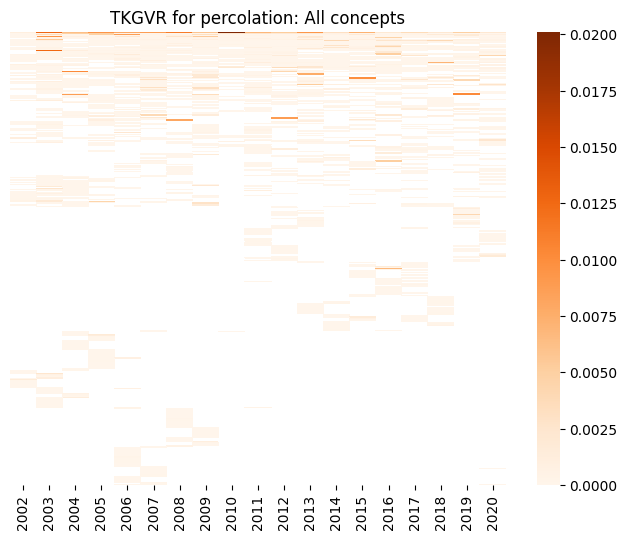

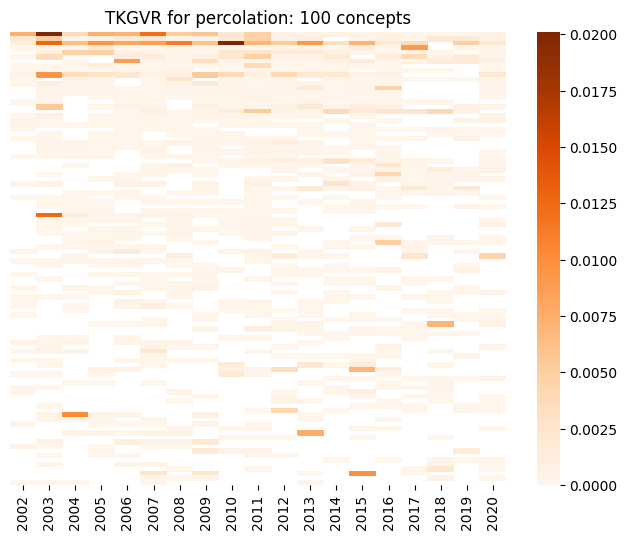

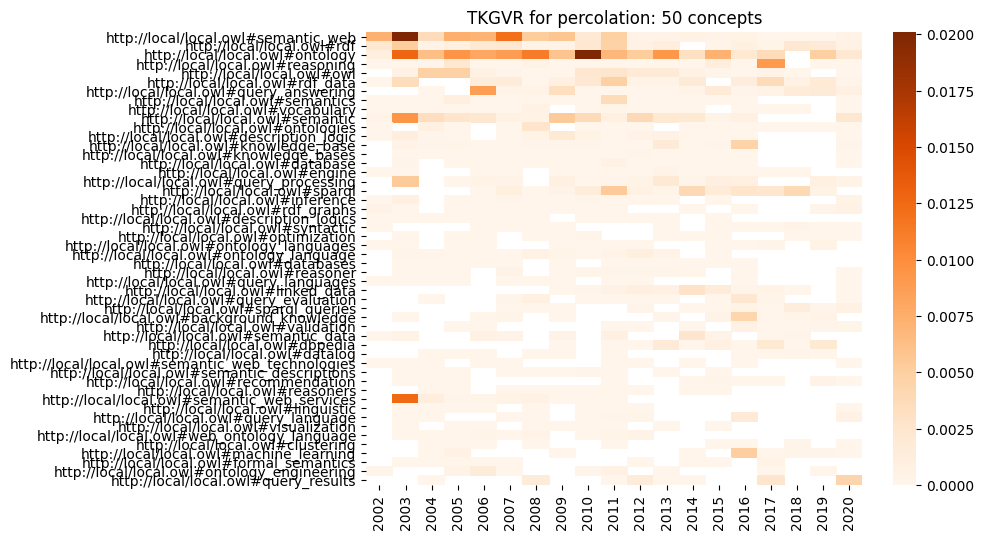

Annual data for degree


,http://local/local.owl#semantic_web,http://local/local.owl#rdf,http://local/local.owl#ontology,http://local/local.owl#semantics,http://local/local.owl#semantic,http://local/local.owl#ontologies,http://local/local.owl#rdf_data,http://local/local.owl#software,http://local/local.owl#xml,http://local/local.owl#semantic_web_technologies,http://local/local.owl#world_wide_web,http://local/local.owl#web_resources,http://local/local.owl#software_agents,http://local/local.owl#intelligent_software_agents,http://local/local.owl#web_mining,http://local/local.owl#knowledge_sharing,http://local/local.owl#resource_description_framework,http://local/local.owl#semantic_web_applications,http://local/local.owl#social_network_analysis,http://local/local.owl#artificial_intelligence,http://local/local.owl#open_source_project,http://local/local.owl#inference_engine,http://local/local.owl#description_logic,http://local/local.owl#internet,http://local/local.owl#relational_database_systems,http://local/local.owl#rdf_graphs,http://local/local.owl#virtual_communities,http://local/local.owl#web_service_descriptions,http://local/local.owl#application_layer,http://local/local.owl#layered,http://local/local.owl#statistical_analysis,http://local/local.owl#ontology_languages,http://local/local.owl#web_information,http://local/local.owl#grid_services,http://local/local.owl#knowledge_representation,http://local/local.owl#semantic_annotations,http://local/local.owl#query_languages,http://local/local.owl#web_services_descriptions,http://local/local.owl#learning_objects,http://local/local.owl#domain_ontology,...,http://local/local.owl#mechanism_design,http://local/local.owl#feature_models,http://local/local.owl#network_architecture,http://local/local.owl#sat_solver,http://local/local.owl#graphbased_representation,http://local/local.owl#relational_learning,http://local/local.owl#type_safety,http://local/local.owl#complex_question,http://local/local.owl#computing_systems,http://local/local.owl#sales,http://local/local.owl#random_walk_algorithm,http://local/local.owl#syntactic__information,http://local/local.owl#truthful_mechanisms,http://local/local.owl#statistic,http://local/local.owl#interpretability,http://local/local.owl#raster_data,http://local/local.owl#cold_start_problem,http://local/local.owl#boosting,http://local/local.owl#query_optimizer,http://local/local.owl#interpreter,http://local/local.owl#combinatorial_optimization_problem,http://local/local.owl#syntactic_structure,http://local/local.owl#web_graph,http://local/local.owl#classification_model,http://local/local.owl#data_protection,http://local/local.owl#gaussian_distributions,http://local/local.owl#search_behaviors,http://local/local.owl#classification_models,http://local/local.owl#similar_cases,http://local/local.owl#random_walks,http://local/local.owl#collaborative_filtering,http://local/local.owl#cold_start,http://local/local.owl#classification_approaches,http://local/local.owl#interleaves,http://local/local.owl#search_session,http://local/local.owl#steiner_tree,http://local/local.owl#text_categorization,http://local/local.owl#supervised_classifiers,http://local/local.owl#efficient_computation,http://local/local.owl#online_learning
2002,0.013303,0.005404,0.004365,0.004365,0.003949,0.003741,0.003326,0.002286,0.002079,0.002079,0.002079,0.001663,0.001663,0.001663,0.001455,0.001455,0.001455,0.001455,0.001455,0.001455,0.001455,0.001247,0.001247,0.001247,0.001247,0.001247,0.001247,0.001247,0.001247,0.001247,0.001247,0.001247,0.001247,0.001247,0.001247,0.001247,0.001247,0.001247,0.001247,0.001247,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003,0.007317,0.003096,0.006332,0.003518,0.005347,NaN,0.000704,0.000704,0.000844,0.000985,0.001688,0.001407,0.000844,NaN,NaN,NaN,0.000844,NaN,NaN,NaN,NaN,0.000844,0.000704,0.000422,NaN,0.000704,NaN,NaN,NaN,NaN,NaN,0.001266,NaN,NaN,NaN,0.000844,0.000704,N

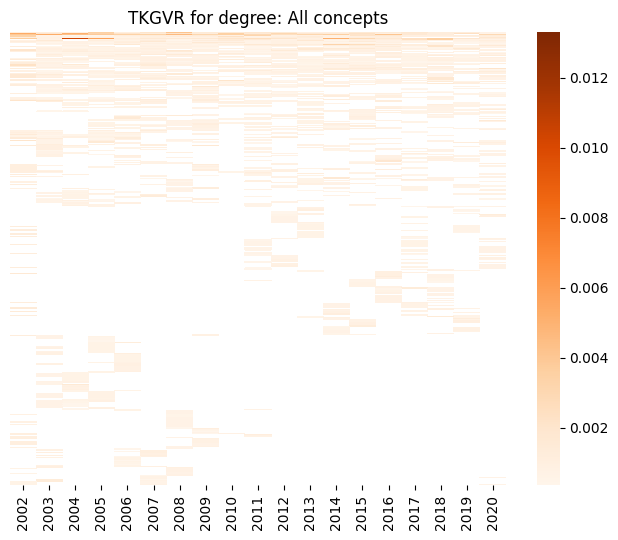

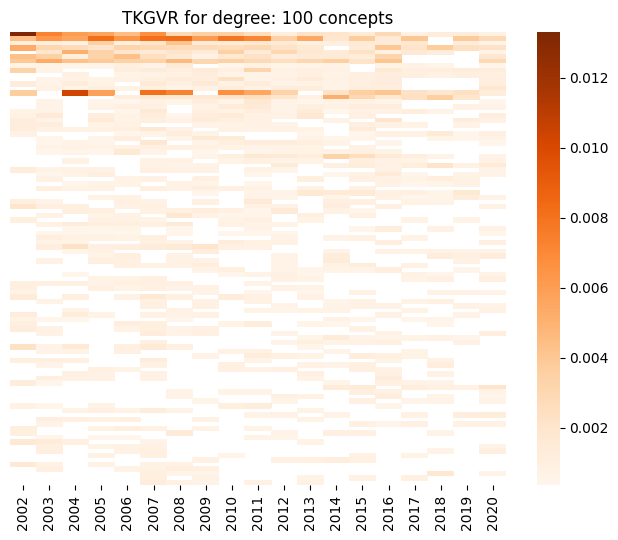

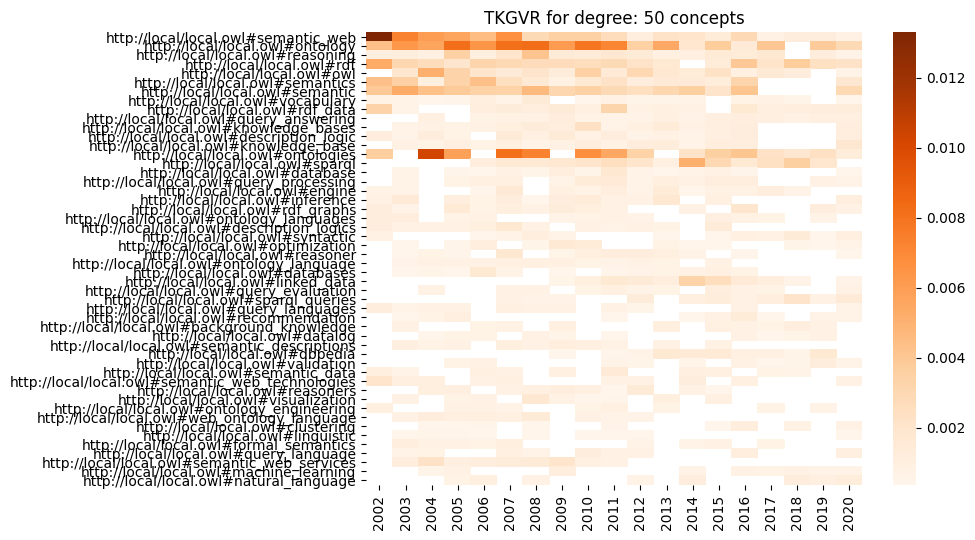

Annual data for eigenvector


,http://local/local.owl#semantics,http://local/local.owl#learning_objects,http://local/local.owl#rdf,http://local/local.owl#rdf_data,http://local/local.owl#process_model,http://local/local.owl#rdf_graphs,http://local/local.owl#semantic_web,http://local/local.owl#software_agents,http://local/local.owl#ontology,http://local/local.owl#web_mining,http://local/local.owl#software,http://local/local.owl#web_resources,http://local/local.owl#web_information,http://local/local.owl#ontologies,http://local/local.owl#semantic_web_technologies,http://local/local.owl#semantic_web_applications,http://local/local.owl#ontology_languages,http://local/local.owl#ontology_development,http://local/local.owl#ontology_engineering,http://local/local.owl#ontology_construction,http://local/local.owl#web_services_descriptions,http://local/local.owl#automation,http://local/local.owl#web_service_descriptions,http://local/local.owl#engineering,http://local/local.owl#information_retrieval,http://local/local.owl#content_providers,http://local/local.owl#domain_experts,http://local/local.owl#domain_ontology,http://local/local.owl#resource_sharing,http://local/local.owl#resource_description_framework,http://local/local.owl#description_logic,http://local/local.owl#description_logics,http://local/local.owl#knowledge_sharing,http://local/local.owl#knowledge_representation,http://local/local.owl#business_environment,http://local/local.owl#logic_programming,http://local/local.owl#semantic_annotations,http://local/local.owl#process_models,http://local/local.owl#consistency_checking,http://local/local.owl#engine,...,http://local/local.owl#word_embeddings,http://local/local.owl#type_safety,http://local/local.owl#video_game,http://local/local.owl#revenue,http://local/local.owl#local_reasoning,http://local/local.owl#graphbased_representation,http://local/local.owl#multihop,http://local/local.owl#sat_solver,http://local/local.owl#complex_question,http://local/local.owl#heterogeneous_databases,http://local/local.owl#random_walk_algorithm,http://local/local.owl#syntactic__information,http://local/local.owl#peertopeer_systems,http://local/local.owl#truthful_mechanisms,http://local/local.owl#statistic,http://local/local.owl#data_protection,http://local/local.owl#raster_data,http://local/local.owl#web_graph,http://local/local.owl#interpreter,http://local/local.owl#query_optimizer,http://local/local.owl#random_walks,http://local/local.owl#text_categorization,http://local/local.owl#syntactic_structure,http://local/local.owl#classification_models,http://local/local.owl#classification_model,http://local/local.owl#classification_approaches,http://local/local.owl#search_behaviors,http://local/local.owl#search_session,http://local/local.owl#combinatorial_optimization_problem,http://local/local.owl#steiner_tree,http://local/local.owl#gaussian_distributions,http://local/local.owl#similar_cases,http://local/local.owl#collaborative_filtering,http://local/local.owl#efficient_computation,http://local/local.owl#boosting,http://local/local.owl#cold_start_problem,http://local/local.owl#cold_start,http://local/local.owl#online_learning,http://local/local.owl#supervised_classifiers,http://local/local.owl#interleaves
2002,1.697848e-02,0.009211,6.516645e-03,5.385694e-03,0.002693,2.692847e-03,1.998862e-03,1.800729e-03,0.001407,0.001250,1.113671e-03,0.000910,0.00091,8.755960e-04,8.254078e-04,0.000825,0.000582,0.000582,0.000582,0.000582,0.000394,3.943350e-04,0.000394,2.408699e-04,0.000174,0.000108,8.126780e-05,8.126780e-05,0.000004,2.385555e-06,1.476519e-06,1.476519e-06,1.395067e-06,0.000001,0.000001,5.654579e-07,1.137789e-10,2.178241e-12,4.529711e-13,1.202778e-13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003,6.664130e-03,NaN,3.378645e-02,1.058565e-02,0.001807,1.058565e-02,1.235879e-01,5.520184e-03,0.081782,NaN,1.271818e-09,0.030174,NaN,NaN,3.908757e-02,NaN,0.029792,0.025664,NaN,0

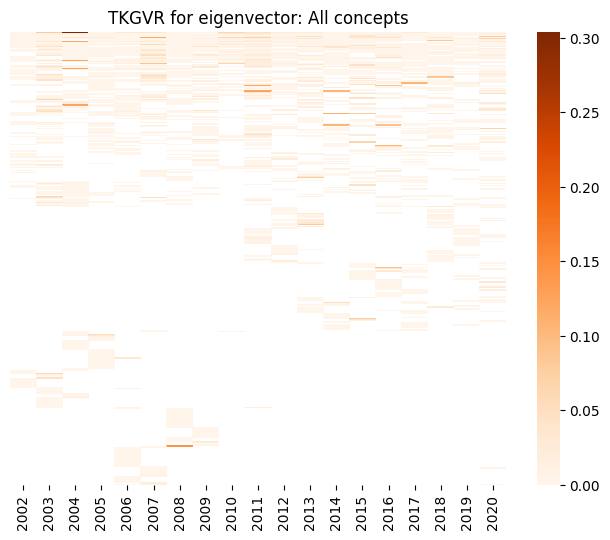

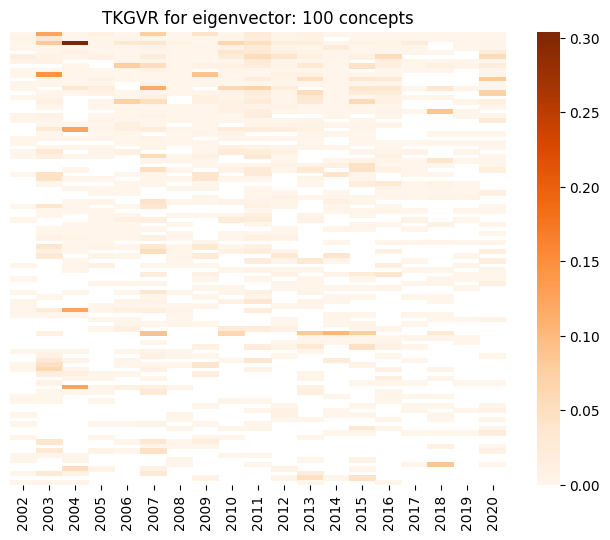

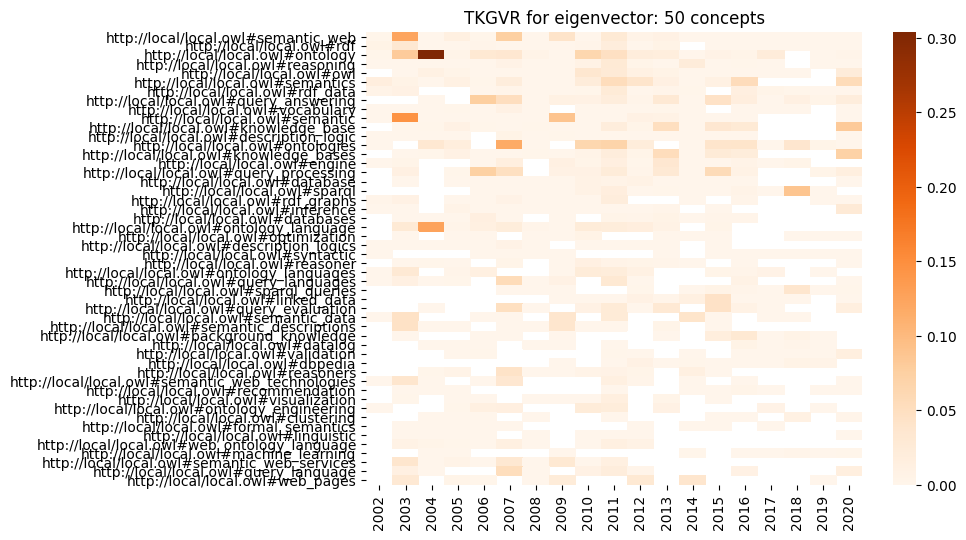

In [6]:
for metric in all_metrics:
    df = create_df(metric=metric, verbose=True)

    plot_df_heatmap(df, title=f'TKGVR for {metric}: All concepts')
    plot_df_heatmap(df, title=f'TKGVR for {metric}: 100 concepts', num_lines=100)
    plot_df_heatmap(df, title=f'TKGVR for {metric}: 50 concepts', num_lines=50)

### Method to plot a series

In [7]:
def plot_series(df, x, y, breakpoints=[], title="", xlabel='Year', ylabel='Value', dpi=100, type='line'):
    plt.figure(figsize=(12,5), dpi=dpi)
    if type == 'bar':
        plt.bar(x, y)
    else:
        plt.plot(x, y, 'o-')
        plt.grid()
    for i in breakpoints:
        plt.axvline(i, color='red', linestyle='dashed')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

## Print a series that describes a given concept evolution over the years, considering a specific metric

In [8]:
metric_of_interest = "harmonic"
concept_of_interest = 'http://local/local.owl#ontology'

metric_df = create_df(metric=metric_of_interest)
concept_series = df[concept_of_interest]
concept_series

2002    0.001407
2003    0.081782
2004    0.303851
2005    0.004400
2006    0.031434
2007    0.034709
2008    0.005256
2009    0.000909
2010    0.064553
2011    0.048596
2012    0.020197
2013    0.017866
2014    0.000181
2015    0.007841
2016    0.004639
2017    0.023571
2018         NaN
2019    0.000383
2020    0.002891
Name: http://local/local.owl#ontology, dtype: float64

In [9]:
concept_series.describe()

count    18.000000
mean      0.036359
std       0.070862
min       0.000181
25%       0.003269
50%       0.012853
75%       0.033891
max       0.303851
Name: http://local/local.owl#ontology, dtype: float64

## Method to determine the trend of a Series

In [10]:
import numpy as np

def trendline(series, order=1):
    if len(set(series)) == 1: # constant data
       return 0

    coeffs = np.polyfit(series.index.values.astype(int), list(series.fillna(0)), order)
    slope = coeffs[-2]
    return float(slope)

def get_trend(series):
    series_slope = trendline(concept_series)
    if series_slope > 0:
        return f'Increasing (slope: {series_slope})'
    elif series_slope < 0:
        return f'Decreasing (slope: {series_slope})' 
    else:
        return f'Neutral (slope: {series_slope})'

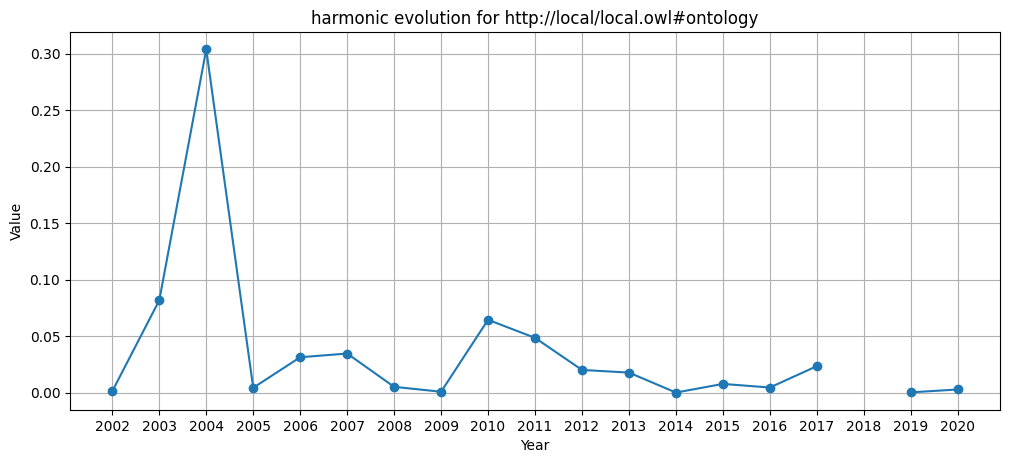

Trend: Decreasing (slope: -0.005117338012875893)
Max. value on 2004: 0.3038508330218441
Min. value on 2014: 0.00018088669608450303


In [11]:
plot_series(concept_series, x=concept_series.index, y=concept_series.values,\
        title='{} evolution for {}'.format(metric_of_interest, concept_of_interest))

print(f'Trend: {get_trend(concept_series)}')
print(f'Max. value on {concept_series.idxmax()}: {concept_series.loc[concept_series.idxmax()]}')
print(f'Min. value on {concept_series.idxmin()}: {concept_series.loc[concept_series.idxmin()]}')

## Detect breakpoints in a series 

In [12]:
pip install jenkspy

     |████████████████████████████████| 55 kB 3.0 MB/s 
  Created wheel for jenkspy: filename=jenkspy-0.2.0-cp37-cp37m-linux_x86_64.whl size=70404 sha256=010878de73430365734c9007e025863a88ee41365734e5b113b4e4b79de432d0
  Stored in directory: /root/.cache/pip/wheels/d8/d1/42/9bd05164ef706b84674905892f0542f8db6ac4a652473ca7e0
Successfully built jenkspy


In [13]:
import jenkspy

# From:
# https://medium.com/analytics-vidhya/jenks-natural-breaks-best-range-finder-algorithm-8d1907192051
# https://pbpython.com/natural-breaks.html
def goodness_of_variance_fit(array, classes):
    # get the break points
    classes = jenkspy.jenks_breaks(array, nb_class=classes)

    # do the actual classification
    classified = np.array([classify(i, classes) for i in array])

    # max value of zones
    maxz = max(classified)

    # nested list of zone indices
    zone_indices = [[idx for idx, val in enumerate(classified) if zone + 1 == val] for zone in range(maxz)]

    # sum of squared deviations from array mean
    sdam = np.sum((array - array.mean()) ** 2)

    # sorted polygon stats
    array_sort = [np.array([array[index] for index in zone]) for zone in zone_indices]

    # sum of squared deviations of class means
    sdcm = sum([np.sum((classified - classified.mean()) ** 2) for classified in array_sort])

    # goodness of variance fit
    gvf = (sdam - sdcm) / sdam

    return gvf

def classify(value, breaks):
    for i in range(1, len(breaks)):
        if value < breaks[i]:
            return i
    return len(breaks) - 1

def get_breakpoints(series):
    gvf = 0.0
    nclasses = 2
    while gvf < .8:
        gvf = goodness_of_variance_fit(series.fillna(0), nclasses)
        nclasses += 1

    breaks_values = jenkspy.jenks_breaks(series, nb_class=nclasses)
    breaks = []
    for v in breaks_values:
        if v == 0: # NaN case
            continue
        idx = concept_series.index.values[concept_series == v][0]
        breaks.append(idx)
    return breaks

In [14]:
plot_series(concept_series, breakpoints=get_breakpoints(concept_series), x=concept_series.index, y=concept_series.values,\
        title='Breakpoints in the {} evolution for {}'.format(metric_of_interest, concept_of_interest))

ValueError: ignored